In [1]:
import requests
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from bs4 import BeautifulSoup
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

soup = BeautifulSoup(source, 'html5lib')

postal_codes_dict = {} # initialize an empty dictionary to save the data in
for table_cell in soup.find_all('td'):
    try:
        postal_code = table_cell.p.b.text # get the postal code
        postal_code_investigate = table_cell.span.text
        neighborhoods_data = table_cell.span.text # get the rest of the data in the cell
        borough = neighborhoods_data.split('(')[0] # get the borough in the cell
        
        # if the cell is not assigned then ignore it
        if neighborhoods_data == 'Not assigned':
            neighborhoods = []
        # else process the data and add it to the dictionary
        else:
            postal_codes_dict[postal_code] = {}
            
            try:
                neighborhoods = neighborhoods_data.split('(')[1]
            
                # remove parantheses from neighborhoods string
                neighborhoods = neighborhoods.replace('(', ' ')
                neighborhoods = neighborhoods.replace(')', ' ')

                neighborhoods_names = neighborhoods.split('/')
                neighborhoods_clean = ', '.join([name.strip() for name in neighborhoods_names])
            except:
                borough = borough.strip('\n')
                neighborhoods_clean = borough
 
            # add borough and neighborhood to dictionary
            postal_codes_dict[postal_code]['borough'] = borough
            postal_codes_dict[postal_code]['neighborhoods'] = neighborhoods_clean
    except:
        pass
    
# create an empty dataframe
columns = ['Postal Code', 'Borough', 'Neighbourhood']
df_raw = pd.DataFrame(columns=columns)
df_raw

# populate dataframe with data from dictionary
for ind, postal_code in enumerate(postal_codes_dict):
    borough = postal_codes_dict[postal_code]['borough']
    neighborhood = postal_codes_dict[postal_code]['neighborhoods']
    df_raw = df_raw.append({"Postal Code": postal_code, 
                                        "Borough": borough, 
                                        "Neighbourhood": neighborhood},
                                        ignore_index=True)

# print number of rows of dataframe
df_raw.shape[0]

103

In [3]:
df_raw.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


#### Data Cleaning

In [4]:
df = df_raw[df_raw.Borough != 'Not assigned']
df.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [5]:
df_toronto = df.groupby(['Postal Code', 'Borough'])['Neighbourhood'].apply(lambda x: ', '.join(x))
df_toronto = df_toronto.reset_index()
df_toronto.head()

,Postal Code,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [6]:
# Check if we still have any Neighborhoods that are Not Assigned
df_toronto.loc[df_toronto['Borough'].isin(["Not assigned"])]

,Postal Code,Borough,Neighbourhood


In [7]:
df_geo=pd.read_csv('Geospatial_Coordinates.csv')
df_geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [8]:
df_toronto = df_toronto.merge(df_geo, on= ['Postal Code','Postal Code'], how = 'left')
df_toronto.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [9]:
df_toronto['Borough'].value_counts()

North York                                                      24
Scarborough                                                     17
Downtown Toronto                                                17
Etobicoke                                                       11
Central Toronto                                                  9
West Toronto                                                     6
York                                                             5
East Toronto                                                     4
East York                                                        4
East TorontoBusiness reply mail Processing Centre969 Eastern     1
MississaugaCanada Post Gateway Processing Centre                 1
Queen's Park                                                     1
Downtown TorontoStn A PO Boxes25 The Esplanade                   1
EtobicokeNorthwest                                               1
East YorkEast Toronto                                         

In [10]:
#Obtain the coordinates from the dataset itself, just averaging Latitude/Longitude of the current dataset 
lat_toronto = df_toronto['Latitude'].mean()
lon_toronto = df_toronto['Longitude'].mean()
print('The geographical coordinates of Toronto are {}, {}'.format(lat_toronto, lon_toronto))

The geographical coordinates of Toronto are 43.70460773398059, -79.39715291165048


In [11]:
CLIENT_ID = 'XE50LMYN3EHYK0QQ1AUPUEO5IAN15PHB3SR0ZRZFU11I52B0' # Foursquare ID
CLIENT_SECRET = 'XWZMXWRGWW2RL2IKE2NEFEKQP4B24O30XNB4WXUYIG4I33RP' # Foursquare Secret
VERSION = 20200514 # Foursquare API version

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
toronto_venues = getNearbyVenues(names=df_toronto['Neighbourhood'],
                                latitudes=df_toronto['Latitude'],
                                longitudes=df_toronto['Longitude'])

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Don Mills South
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
The Danforth  East
The Danforth West, Riverdale


In [14]:
toronto_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Chris Effects Painting,43.784343,-79.163742,Construction & Landscaping
2,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,SEBS Engineering Inc. (Sustainable Energy and ...,43.782371,-79.156820,Construction & Landscaping
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank


In [15]:
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",21,21,21,21,21,21
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",24,24,24,24,24,24
...,...,...,...,...,...,...
Willowdale South,33,33,33,33,33,33
Willowdale West,5,5,5,5,5,5
Woburn,4,4,4,4,4,4


#### Unique Venues

In [16]:
toronto_venues['Venue Category'].unique()

array(['Fast Food Restaurant', 'Construction & Landscaping', 'Bar',
       'Bank', 'Electronics Store', 'Restaurant', 'Mexican Restaurant',
       'Rental Car Location', 'Donut Shop', 'Medical Center',
       'Intersection', 'Breakfast Spot', 'Coffee Shop',
       'Korean BBQ Restaurant', 'Pharmacy', 'Hakka Restaurant',
       'Caribbean Restaurant', 'Thai Restaurant', 'Athletics & Sports',
       'Bakery', 'Gas Station', 'Fried Chicken Joint', 'Playground',
       'Jewelry Store', 'Department Store', 'Bus Station',
       'Ice Cream Shop', 'Bus Line', 'Metro Station', 'Park',
       'Soccer Field', 'Motel', 'American Restaurant', 'Skating Rink',
       'Café', 'General Entertainment', 'College Stadium',
       'Chinese Restaurant', 'Indian Restaurant', 'Vietnamese Restaurant',
       'Pet Store', 'Sandwich Place', 'Middle Eastern Restaurant',
       'Shopping Mall', 'Smoke Shop', 'Auto Garage',
       'Latin American Restaurant', 'Lounge', 'Italian Restaurant',
       'Noodle House', 

In [17]:
toronto_venues['Venue Category'].value_counts()

Coffee Shop             186
Café                     93
Restaurant               63
Park                     54
Pizza Place              51
                       ... 
Harbor / Marina           1
Shopping Plaza            1
Video Store               1
Taiwanese Restaurant      1
Sake Bar                  1
Name: Venue Category, Length: 273, dtype: int64

In [18]:
# one hot encoding
to_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighbourhoods'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

(2126, 274)


,Neighbourhoods,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Rouge Hill, Port Union, Highland Creek",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Rouge Hill, Port Union, Highland Creek",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Rouge Hill, Port Union, Highland Creek",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
to_grouped = to_onehot.groupby(["Neighbourhoods"]).mean().reset_index()

print(to_grouped.shape)
to_grouped.head()

(99, 274)


,Neighbourhoods,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
pizza = to_grouped[["Neighbourhoods","Pizza Place"]]
pizza = pizza.rename(columns={'Neighbourhoods':'Neighbourhood'})
pizza.head()

,Neighbourhood,Pizza Place
0,Agincourt,0.000000
1,"Alderwood, Long Branch",0.250000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.047619
3,Bayview Village,0.000000
4,"Bedford Park, Lawrence Manor East",0.083333


#### Neighbourhood Clustering

In [21]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)
X = pizza.drop(['Neighbourhood'], axis=1)

In [22]:
kmeans.fit(X)
kmeans.labels_[0:10]

array([0, 2, 0, 0, 0, 0, 0, 0, 0, 0])

In [23]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [24]:
scores = [get_inertia(x) for x in range(2, 21)]

Text(0, 0.5, 'Error')

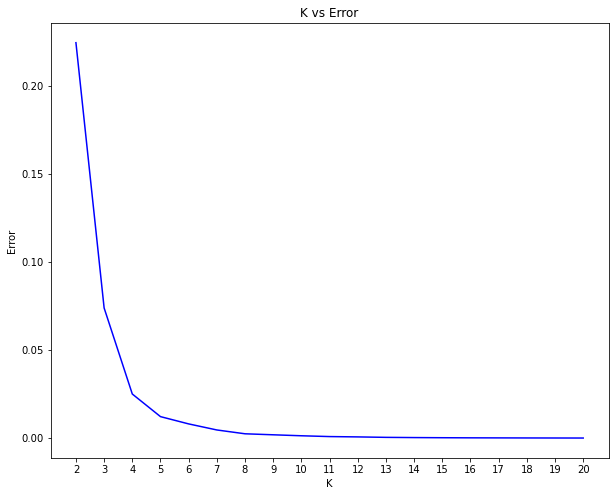

In [25]:
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores, color='b')
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")

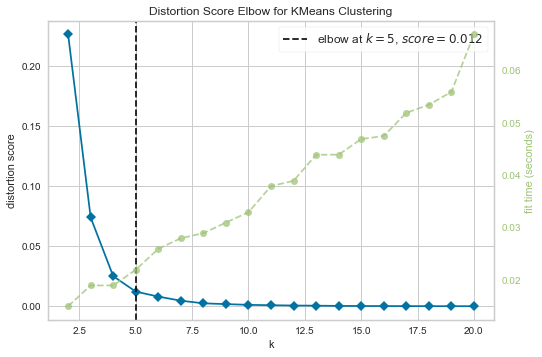

In [26]:
from yellowbrick.cluster import KElbowVisualizer
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,21))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()

In [27]:
kclusters = 5

toronto_grouped_clustering = pizza.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 2, 4, 0, 4, 0, 0, 0, 0, 0])

In [28]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
to_merged = pizza.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_
to_merged.head()

,Neighbourhood,Pizza Place,Cluster Labels
0,Agincourt,0.000000,0
1,"Alderwood, Long Branch",0.250000,2
2,"Bathurst Manor, Wilson Heights, Downsview North",0.047619,4
3,Bayview Village,0.000000,0
4,"Bedford Park, Lawrence Manor East",0.083333,4


In [29]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
to_merged = to_merged.join(toronto_venues.set_index("Neighbourhood"), on="Neighbourhood")

print(to_merged.shape)
to_merged.head()

(2126, 9)


,Neighbourhood,Pizza Place,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt,0.00,0,43.794200,-79.262029,Panagio's Breakfast & Lunch,43.792370,-79.260203,Breakfast Spot
0,Agincourt,0.00,0,43.794200,-79.262029,El Pulgarcito,43.792648,-79.259208,Latin American Restaurant
0,Agincourt,0.00,0,43.794200,-79.262029,Twilight,43.791999,-79.258584,Lounge
0,Agincourt,0.00,0,43.794200,-79.262029,Commander Arena,43.794867,-79.267989,Skating Rink
1,"Alderwood, Long Branch",0.25,2,43.602414,-79.543484,Il Paesano Pizzeria & Restaurant,43.601280,-79.545028,Pizza Place


In [30]:
# sort the results by Cluster Labels
print(to_merged.shape)
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged

(2126, 9)


,Neighbourhood,Pizza Place,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt,0.000000,0,43.794200,-79.262029,Panagio's Breakfast & Lunch,43.792370,-79.260203,Breakfast Spot
53,"Little Portugal, Trinity",0.022727,0,43.647927,-79.419750,Pilot Coffee Roasters,43.646610,-79.419606,Coffee Shop
53,"Little Portugal, Trinity",0.022727,0,43.647927,-79.419750,Jimmy's Coffee,43.644521,-79.418908,Coffee Shop
53,"Little Portugal, Trinity",0.022727,0,43.647927,-79.419750,Ufficio,43.649439,-79.423014,Italian Restaurant
53,"Little Portugal, Trinity",0.022727,0,43.647927,-79.419750,Pho Tien Thanh,43.645484,-79.419276,Vietnamese Restaurant
...,...,...,...,...,...,...,...,...,...
77,"St. James Town, Cabbagetown",0.042553,4,43.667967,-79.367675,Cafe Olya,43.666600,-79.368893,Coffee Shop
77,"St. James Town, Cabbagetown",0.042553,4,43.667967,-79.367675,Tender Trap Restaurant,43.667724,-79.369485,Chinese Restaurant
77,"St. James Town, Cabbagetown",0.042553,4,43.667967,-79.367675,El Charro,43.667606,-79.369490,Restaurant
77,"St. James Town, Cabbagetown",0.042553,4,43.667967,-79.367675,The Flying Beaver Pubaret,43.664829,-79.368292,Pub


In [31]:
to_merged['Venue Category'].value_counts()['Pizza Place']

51

In [32]:
map_clusters = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Neighbourhood Latitude'], to_merged['Neighbourhood Longitude'], to_merged['Neighbourhood'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

#### Neighbourhood Per Cluster

In [33]:
pizza["Cluster Labels"] = kmeans.labels_
pizza.head()

,Neighbourhood,Pizza Place,Cluster Labels
0,Agincourt,0.000000,0
1,"Alderwood, Long Branch",0.250000,2
2,"Bathurst Manor, Wilson Heights, Downsview North",0.047619,4
3,Bayview Village,0.000000,0
4,"Bedford Park, Lawrence Manor East",0.083333,4


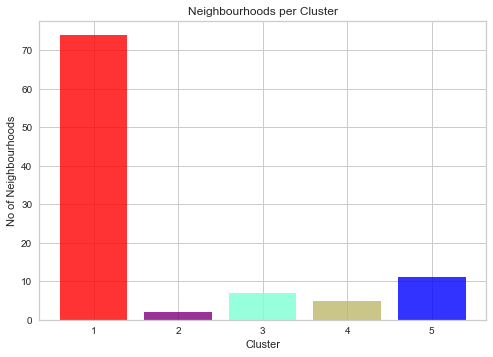

In [34]:
objects = (1,2,3,4,5)
y_pos = np.arange(len(objects))
performance = pizza['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki', 'blue'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighbourhoods')
plt.xlabel('Cluster')
plt.title('Neighbourhoods per Cluster')

plt.show()

In [35]:
pizza['Cluster Labels'].value_counts()

0    74
4    11
2     7
3     5
1     2
Name: Cluster Labels, dtype: int64

#### Cluster 1

In [36]:
df_new = df[['Borough', 'Neighbourhood']]
cluster1 = to_merged.loc[to_merged['Cluster Labels'] == 0]
df_cluster1 = pd.merge(df_new, cluster1, on='Neighbourhood')
df_cluster1.head()

,Borough,Neighbourhood,Pizza Place,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North York,Parkwoods,0.0,0,43.753259,-79.329656,Corrosion Service Company Limited,43.752432,-79.334661,Construction & Landscaping
1,North York,Parkwoods,0.0,0,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,North York,Parkwoods,0.0,0,43.753259,-79.329656,Brookbanks Pool,43.751389,-79.332184,Pool
3,North York,Parkwoods,0.0,0,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
4,Downtown Toronto,"Regent Park, Harbourfront",0.0,0,43.654260,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop


In [37]:
df_cluster1['Venue Category'].nunique()

260

In [38]:
df_cluster1['Neighbourhood'].nunique()

74

In [39]:
df_cluster1['Neighbourhood'].value_counts()

Harbourfront East, Union Station, Toronto Islands                         100
First Canadian Place, Underground city                                    100
Toronto Dominion Centre, Design Exchange                                  100
Commerce Court, Victoria Hotel                                            100
Garden District, Ryerson                                                  100
                                                                         ... 
York Mills West                                                             2
The Kingsway, Montgomery Road, Old Mill North                               1
Humberlea, Emery                                                            1
Malvern, Rouge                                                              1
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale      1
Name: Neighbourhood, Length: 74, dtype: int64

In [40]:
df_cluster1['Borough'].value_counts()

Downtown Toronto                                    1045
West Toronto                                         160
North York                                           145
Downtown TorontoStn A PO Boxes25 The Esplanade        99
East Toronto                                          84
Scarborough                                           68
East York                                             38
Central Toronto                                       32
Queen's Park                                          29
Etobicoke                                             21
MississaugaCanada Post Gateway Processing Centre      14
York                                                  14
EtobicokeNorthwest                                     5
East YorkEast Toronto                                  3
Name: Borough, dtype: int64

In [41]:
df_cluster1['Pizza Place'].mean()

0.008537279453614068

In [42]:
cluster1 = df_cluster1.copy()
cluster1 = cluster1[cluster1['Venue Category'] == 'Pizza Place']
cluster1.head()

,Borough,Neighbourhood,Pizza Place,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
168,Downtown Toronto,"Garden District, Ryerson",0.020000,0,43.657162,-79.378937,Panago,43.658258,-79.384313,Pizza Place
192,Downtown Toronto,"Garden District, Ryerson",0.020000,0,43.657162,-79.378937,Blaze Pizza,43.656518,-79.380015,Pizza Place
449,Downtown Toronto,Central Bay Street,0.015625,0,43.657952,-79.387383,Panago,43.658258,-79.384313,Pizza Place
575,Downtown Toronto,"Richmond, Adelaide, King",0.021739,0,43.650571,-79.384568,Pizzeria Libretto,43.648334,-79.385111,Pizza Place
583,Downtown Toronto,"Richmond, Adelaide, King",0.021739,0,43.650571,-79.384568,Pi Co.,43.648651,-79.385874,Pizza Place


In [43]:
cluster1['Borough'].value_counts()

Downtown Toronto    12
West Toronto         2
East Toronto         1
Name: Borough, dtype: int64

In [44]:
cluster1['Neighbourhood'].value_counts()

Harbourfront East, Union Station, Toronto Islands    2
Garden District, Ryerson                             2
First Canadian Place, Underground city               2
Richmond, Adelaide, King                             2
Little Portugal, Trinity                             1
Church and Wellesley                                 1
The Danforth West, Riverdale                         1
Commerce Court, Victoria Hotel                       1
Central Bay Street                                   1
Kensington Market, Chinatown, Grange Park            1
Runnymede, Swansea                                   1
Name: Neighbourhood, dtype: int64

#### Cluster 2

In [45]:
cluster2=to_merged.loc[to_merged['Cluster Labels'] == 1]
df_cluster2 = pd.merge(df_new, cluster2, on='Neighbourhood')
df_cluster2.head()

,Borough,Neighbourhood,Pizza Place,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North York,Humber Summit,0.5,1,43.756303,-79.565963,Pizza Monza,43.755043,-79.567195,Pizza Place
1,North York,Humber Summit,0.5,1,43.756303,-79.565963,Faab Fitness,43.758156,-79.570442,Gym
2,York,"Runnymede, The Junction North",0.5,1,43.673185,-79.487262,195 Jane Rocket,43.672335,-79.492634,Bus Line
3,York,"Runnymede, The Junction North",0.5,1,43.673185,-79.487262,241 Pizza,43.672351,-79.492631,Pizza Place


In [46]:
df_cluster2['Venue Category'].nunique()

3

In [47]:
df_cluster2['Neighbourhood'].nunique()

2

In [48]:
df_cluster2['Venue Category'].value_counts()

Pizza Place    2
Gym            1
Bus Line       1
Name: Venue Category, dtype: int64

In [49]:
df_cluster2['Borough'].value_counts()

York          2
North York    2
Name: Borough, dtype: int64

In [50]:
df_cluster2['Pizza Place'].mean()

0.5

In [51]:
cluster2 = df_cluster2.copy()
cluster2 = cluster2[cluster2['Venue Category'] == 'Pizza Place']
cluster2.head()

,Borough,Neighbourhood,Pizza Place,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North York,Humber Summit,0.5,1,43.756303,-79.565963,Pizza Monza,43.755043,-79.567195,Pizza Place
3,York,"Runnymede, The Junction North",0.5,1,43.673185,-79.487262,241 Pizza,43.672351,-79.492631,Pizza Place


In [52]:
cluster2['Borough'].value_counts()

York          1
North York    1
Name: Borough, dtype: int64

#### Cluster 3

In [53]:
cluster3=to_merged.loc[to_merged['Cluster Labels'] == 2]
df_cluster3 = pd.merge(df_new, cluster3, on='Neighbourhood')
df_cluster3.head()

,Borough,Neighbourhood,Pizza Place,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North York,Victoria Village,0.2,2,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
1,North York,Victoria Village,0.2,2,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
2,North York,Victoria Village,0.2,2,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
3,North York,Victoria Village,0.2,2,43.725882,-79.315572,Eglinton Ave E & Sloane Ave/Bermondsey Rd,43.726086,-79.313620,Intersection
4,North York,Victoria Village,0.2,2,43.725882,-79.315572,Pizza Nova,43.725824,-79.312860,Pizza Place


In [54]:
df_cluster3['Venue Category'].nunique()

28

In [55]:
df_cluster3['Neighbourhood'].nunique()

7

In [56]:
df_cluster3['Borough'].value_counts()

Etobicoke     21
North York    14
East York     11
Name: Borough, dtype: int64

In [57]:
df_cluster3['Pizza Place'].mean()

0.21739130434782608

In [58]:
cluster3 = df_cluster3.copy()
cluster3 = cluster3[cluster3['Venue Category'] == 'Pizza Place']
cluster3.head()

,Borough,Neighbourhood,Pizza Place,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
4,North York,Victoria Village,0.200000,2,43.725882,-79.315572,Pizza Nova,43.725824,-79.312860,Pizza Place
8,East York,"Parkview Hill, Woodbine Gardens",0.181818,2,43.706397,-79.309937,Venice Pizza,43.705921,-79.313957,Pizza Place
11,East York,"Parkview Hill, Woodbine Gardens",0.181818,2,43.706397,-79.309937,Pizza Pizza,43.705159,-79.313130,Pizza Place
17,North York,Glencairn,0.250000,2,43.709577,-79.445073,Domino's Pizza,43.707170,-79.442658,Pizza Place
26,Etobicoke,Westmount,0.222222,2,43.696319,-79.532242,Pizza Nova,43.692817,-79.531570,Pizza Place


In [59]:
cluster3['Neighbourhood'].value_counts()

Westmount                                                                  2
Parkview Hill, Woodbine Gardens                                            2
Alderwood, Long Branch                                                     2
Glencairn                                                                  1
Kingsview Village, St. Phillips, Martin Grove Gardens, Richview Gardens    1
Willowdale West                                                            1
Victoria Village                                                           1
Name: Neighbourhood, dtype: int64

In [60]:
cluster3['Borough'].value_counts()

Etobicoke     5
North York    3
East York     2
Name: Borough, dtype: int64

#### Cluster 4

In [61]:
cluster4=to_merged.loc[to_merged['Cluster Labels'] == 3]
df_cluster4 = pd.merge(df_new, cluster4, on='Neighbourhood')
df_cluster4.head()

,Borough,Neighbourhood,Pizza Place,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Etobicoke,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",0.1,3,43.643515,-79.577201,LCBO,43.642099,-79.576592,Liquor Store
1,Etobicoke,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",0.1,3,43.643515,-79.577201,Starbucks,43.641312,-79.576924,Coffee Shop
2,Etobicoke,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",0.1,3,43.643515,-79.577201,The Beer Store,43.641313,-79.576925,Beer Store
3,Etobicoke,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",0.1,3,43.643515,-79.577201,Carsbrooke Park,43.647051,-79.576682,Park
4,Etobicoke,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",0.1,3,43.643515,-79.577201,Pet Valu,43.641667,-79.577050,Pet Store


In [62]:
df_cluster4['Venue Category'].nunique()

40

In [63]:
df_cluster4['Neighbourhood'].nunique()

5

In [64]:
df_cluster4['Venue Category'].value_counts()

Pizza Place             10
Sandwich Place           5
Pharmacy                 5
Coffee Shop              3
Café                     3
Convenience Store        3
Italian Restaurant       3
Park                     3
Dessert Shop             3
Grocery Store            2
Thai Restaurant          2
Gym                      2
Gas Station              2
Fried Chicken Joint      2
Sushi Restaurant         2
Beer Store               2
Fast Food Restaurant     2
Chinese Restaurant       1
Breakfast Spot           1
Brewery                  1
Hotel                    1
Bookstore                1
Gym / Fitness Center     1
Toy / Game Store         1
Intersection             1
Shopping Plaza           1
Department Store         1
Gourmet Shop             1
Diner                    1
Seafood Restaurant       1
Pet Store                1
Bank                     1
Liquor Store             1
Shopping Mall            1
Restaurant               1
Indian Restaurant        1
Farmers Market           1
F

In [65]:
df_cluster4['Borough'].value_counts()

Central Toronto    44
Etobicoke          18
Scarborough        15
Name: Borough, dtype: int64

In [66]:
df_cluster4['Pizza Place'].mean()

0.12987012987012997

In [67]:
cluster4 = df_cluster4.copy()
cluster4 = cluster4[cluster4['Venue Category'] == 'Pizza Place']
cluster4.head()

,Borough,Neighbourhood,Pizza Place,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
7,Etobicoke,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",0.100000,3,43.643515,-79.577201,Pizza Hut,43.641514,-79.576326,Pizza Place
10,Central Toronto,Davisville North,0.111111,3,43.712751,-79.390197,Provocative Pizza Series,43.708293,-79.389546,Pizza Place
37,Central Toronto,Davisville,0.142857,3,43.704324,-79.388790,Pizza Pizza,43.706138,-79.389292,Pizza Place
43,Central Toronto,Davisville,0.142857,3,43.704324,-79.388790,Provocative Pizza Series,43.708293,-79.389546,Pizza Place
44,Central Toronto,Davisville,0.142857,3,43.704324,-79.388790,Pizza Nova,43.707524,-79.389863,Pizza Place


In [68]:
cluster4['Neighbourhood'].value_counts()

Davisville                                                                                                       5
Clarks Corners, Tam O'Shanter, Sullivan                                                                          2
South Steeles, Silverstone, Humbergate, Jamestown, Mount Olive, Beaumond Heights, Thistletown, Albion Gardens    1
Davisville North                                                                                                 1
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood                                                    1
Name: Neighbourhood, dtype: int64

In [69]:
cluster4['Borough'].value_counts()

Central Toronto    6
Etobicoke          2
Scarborough        2
Name: Borough, dtype: int64

#### Cluster 5

In [70]:
cluster5 = to_merged.loc[to_merged['Cluster Labels'] == 4]
df_cluster5 = pd.merge(df_new, cluster5, on='Neighbourhood')
df_cluster5.head()

,Borough,Neighbourhood,Pizza Place,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North York,"Bathurst Manor, Wilson Heights, Downsview North",0.047619,4,43.754328,-79.442259,Burnett Park,43.757585,-79.439855,Park
1,North York,"Bathurst Manor, Wilson Heights, Downsview North",0.047619,4,43.754328,-79.442259,Bathurst & Sheppard,43.757535,-79.439953,Intersection
2,North York,"Bathurst Manor, Wilson Heights, Downsview North",0.047619,4,43.754328,-79.442259,Rogers,43.756053,-79.440368,Mobile Phone Shop
3,North York,"Bathurst Manor, Wilson Heights, Downsview North",0.047619,4,43.754328,-79.442259,Shoppers Drug Mart,43.756239,-79.439599,Pharmacy
4,North York,"Bathurst Manor, Wilson Heights, Downsview North",0.047619,4,43.754328,-79.442259,Metro,43.756084,-79.439790,Supermarket


In [71]:
cluster5 = df_cluster5.copy()
cluster5 = cluster5[df_cluster5['Venue Category'] == 'Pizza Place']
cluster5['Venue Category'].value_counts()

Pizza Place    14
Name: Venue Category, dtype: int64

In [72]:
df_cluster5['Venue Category'].nunique()

86

In [73]:
df_cluster5['Neighbourhood'].nunique()

11

In [74]:
df_cluster5['Borough'].value_counts()

North York                                                      78
Downtown Toronto                                                47
Central Toronto                                                 35
East York                                                       23
East Toronto                                                    18
East TorontoBusiness reply mail Processing Centre969 Eastern    16
Scarborough                                                     13
Etobicoke                                                       12
Name: Borough, dtype: int64

In [76]:
df_cluster5['Pizza Place'].mean()

0.05785123966942132

In [77]:
cluster5 = df_cluster5.copy()
cluster5 = cluster5[cluster5['Venue Category'] == 'Pizza Place']
cluster5.head()

,Borough,Neighbourhood,Pizza Place,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
11,North York,"Bathurst Manor, Wilson Heights, Downsview North",0.047619,4,43.754328,-79.442259,Pizza Pizza,43.755311,-79.441126,Pizza Place
30,East York,Thorncliffe Park,0.043478,4,43.705369,-79.349372,Pizza Pizza,43.705564,-79.347139,Pizza Place
44,East Toronto,"India Bazaar, The Beaches West",0.055556,4,43.668999,-79.315572,Pizzaiolo,43.668953,-79.311683,Pizza Place
79,North York,"Bedford Park, Lawrence Manor East",0.083333,4,43.733283,-79.419750,Panago,43.731430,-79.419224,Pizza Place
80,North York,"Bedford Park, Lawrence Manor East",0.083333,4,43.733283,-79.419750,Pizza Pizza,43.731952,-79.415019,Pizza Place


In [80]:
cluster5['Neighbourhood'].value_counts()

Bedford Park, Lawrence Manor East                                    2
Willowdale South                                                     2
St. James Town, Cabbagetown                                          2
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park    1
The Annex, North Midtown, Yorkville                                  1
New Toronto, Mimico South, Humber Bay Shores                         1
Bathurst Manor, Wilson Heights, Downsview North                      1
Thorncliffe Park                                                     1
Steeles West, L'Amoreaux West                                        1
Enclave of M4L                                                       1
India Bazaar, The Beaches West                                       1
Name: Neighbourhood, dtype: int64

In [78]:
cluster5['Borough'].value_counts()

North York                                                      5
Downtown Toronto                                                2
Central Toronto                                                 2
East Toronto                                                    1
Scarborough                                                     1
East York                                                       1
Etobicoke                                                       1
East TorontoBusiness reply mail Processing Centre969 Eastern    1
Name: Borough, dtype: int64

#### Cluster Analysis

Text(0.5, 1.0, 'Average number of Pizza Places per Cluster')

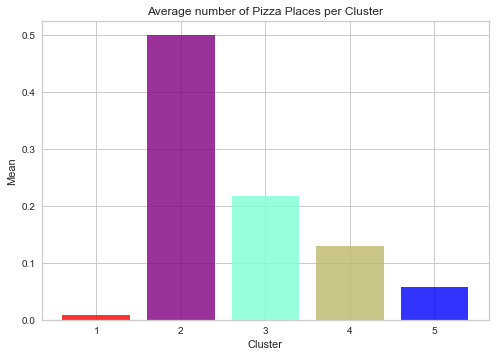

In [79]:
clusters_mean = [df_cluster1['Pizza Place'].mean(),df_cluster2['Pizza Place'].mean(),
                 df_cluster3['Pizza Place'].mean(),df_cluster4['Pizza Place'].mean(),
                df_cluster5['Pizza Place'].mean()]
objects = (1,2,3,4,5)
y_pos = np.arange(len(objects))
perf = clusters_mean
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki','blue'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Pizza Places per Cluster')